<a href="https://github.com/groda/big_data"><div><img src="https://github.com/groda/big_data/blob/master/logo_bdb.png?raw=true" align=right width="90" alt="Logo Big Data for Beginners"></div></a>
# Explore and download books from the Gutenberg Books collection

This Jupyter Notebook provides an interactive exploration and downloading interface for the Gutenberg Books Collection.

Explore the vast collection of books, analyze metadata, and download selected texts based on various criteria. Dive into literary exploration and access timeless classics with ease

**Note:** you can execute the whole "Preliminaries" section while it is collapsed by clicking on the "run" icon. Once all the cells in the "Preliminaries" section have been executed, all other cells can be executed independently of one another.


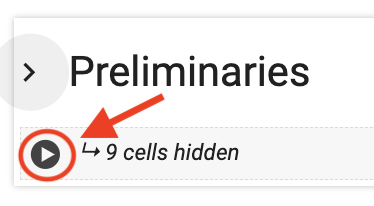

# Preliminaries

## Main class `GutenbergBooks`

In [1]:
import gzip
import urllib.request
import requests
import os
import io
import pandas as pd

GUTENBERG_URL = "https://www.gutenberg.org/cache/epub/feeds/pg_catalog.csv.gz"
GUTENBERG_CACHEDIR = "GutenbergBooks"

pd.options.mode.copy_on_write = True

class GutenbergBooks:
    def __init__(self):
        self.catalog_url = GUTENBERG_URL
        self.catalog_file = self.catalog_url.rsplit('/', 1)[-1][:-3]
        self.is_cached = os.path.isfile(self.catalog_file)
        self.catalog = self.fetch_catalog()
        self.all_subjects = self.get_subjects()
        self.cachedir = GUTENBERG_CACHEDIR

        if not os.path.exists(self.cachedir):
            os.makedirs(self.cachedir)

    def is_cached(self):
        if os.path.isfile(self.catalog_file):
            return True
        return False

    def cache_catalog(self):
        self.catalog = self.fetch_catalog(use_cache=False)
        self.catalog.to_csv(self.catalog_file)
        self.is_cached = True

    def is_book_downloaded(self, bookID):
        book_file = f"pg{bookID}.txt"
        if os.path.isfile(os.path.join(GUTENBERG_CACHEDIR, book_file)):
          return True
        return False

    def fetch_catalog(self, use_cache=True):
        url = self.catalog_url
        filename = self.catalog_file
        if self.is_cached and use_cache:
            print(f"Retrieving {filename} from cache. To refresh cache use cache_catalog()")
            dataframe = pd.read_csv(filename, quotechar = '"')
            return dataframe
        try:
            # Retrieve the compressed file from the URL
            print(f"Retrieving {filename} from {url}.")
            response = urllib.request.urlopen(url)
            compressed_data = response.read()
            # Decompress the data
            decompressed_data = gzip.decompress(compressed_data)
            # Load decompressed data into pandas DataFrame
            dataframe = pd.read_csv(io.StringIO(decompressed_data.decode('utf-8')), quotechar = '"')
            dataframe.to_csv(self.catalog_file)
            self.is_cached = True
            return dataframe
        except Exception as e:
            print("An error occurred:", e)
            return None

    def get_subjects(self):
        return self.catalog['Subjects'].str.split('; ').explode().unique().tolist()

    def random_subjects(self, n, seed):
        """
        This method returns n random subjects.
        Parameters:
        - n (int): number of subjects.
        - seed (int): random seed for reproducibility.
        Returns:
        - list: Random sample of subjects from the Gutenberg Books catalog
                following the subjects distribution.
        """
        df = self.catalog['Subjects']
        subject_counts = df.str.split('; ').explode() \
                           .groupby(df.str.split('; ').explode()).count() \
                           .reset_index(name='Count').sort_values(by='Count', ascending=False) \
                           .rename(columns={"Subjects": "Subject"}) \
                           .reset_index(drop=True)
        return subject_counts.sample(n=n, replace=False, random_state=seed, weights=subject_counts['Count'])

    def topn_subjects(self, n):
        df = self.catalog['Subjects']
        subject_counts = df.str.split('; ').explode() \
                           .groupby(df.str.split('; ').explode()).count() \
                           .reset_index(name='Count').sort_values(by='Count', ascending=False) \
                           .rename(columns={"Subjects": "Subject"})
        return subject_counts.reset_index(drop=True).head(n)

    def get_authors(self):
        return self.catalog['Authors'].str.split('; ').explode().unique().tolist()

    def random_authors(self, n, seed):
        df = self.catalog['Authors']
        author_counts = df.str.split('; ').explode() \
                           .groupby(df.str.split('; ').explode()).count() \
                           .reset_index(name='Count').sort_values(by='Count', ascending=False) \
                           .rename(columns={"Authors": "Author"}) \
                           .reset_index(drop=True)
        return author_counts.sample(n=n, replace=False, random_state=seed, weights=author_counts['Count'])

    def topn_authors(self, n):
        df = self.catalog['Authors']
        author_counts = df.str.split('; ').explode() \
                           .groupby(df.str.split('; ').explode()).count() \
                           .reset_index(name='Count').sort_values(by='Count', ascending=False) \
                           .rename(columns={"Authors": "Author"})
        return author_counts.reset_index(drop=True).head(n)

    def get_languages(self):
        return self.catalog['Language'].str.split('; ').explode().unique().tolist()

    def topn_languages(self, n):
        df = self.catalog['Language']
        language_counts = df.str.split('; ').explode() \
                            .groupby(df.str.split('; ').explode()).count() \
                            .reset_index(name='Count').sort_values(by='Count', ascending=False)
        return language_counts.reset_index(drop=True).head(n)

    def get_bookshelves(self):
        return self.catalog['Bookshelves'].str.split('; ').explode().unique().tolist()

    def topn_bookshelves(self, n):
        df = self.catalog['Bookshelves']
        bookshelf_counts = df.str.split('; ').explode() \
                             .groupby(df.str.split('; ').explode()).count() \
                             .reset_index(name='Count').sort_values(by='Count', ascending=False) \
                             .rename(columns={"Bookshelves": "Bookshelf"})
        return bookshelf_counts.reset_index(drop=True).head(n)

    def get_types(self):
        return self.catalog['Type'].unique().tolist()

    def get_books(self, lang, subject, title):
        return self.catalog.sample(n=n, replace=False, random_state=seed)

    def random_books(self, n, seed):
        return self.catalog.sample(n=n, replace=False, random_state=seed)

    def books_matching_subject(self, substr):
        return self.catalog.query(f'Subjects.str.lower().str.contains("{substr.lower()}", na=False)')

    def books_matching_author(self, substr):
        return self.catalog.query(f'Author.str.lower().str.contains("{substr.lower()}", na=False)')

    def books_matching_year(self, given_year):
        """
        Find books from the catalog that match a given year within the birth-death intervals of authors.

        Parameters:
        - given_year (int): The year to match within the birth-death intervals of authors.

        Returns:
        - DataFrame: A DataFrame containing books from the catalog where the given year falls within
                     the birth-death intervals of authors.

        This method extracts birth and death years from the 'Authors' column of the catalog and filters
        rows where the given year is within any birth-death interval. It returns a DataFrame of matching books.
        """
        catalog_copy = self.catalog.copy()
        # Create a temporary DataFrame to hold split author-interval pairs
        temp_df = catalog_copy['Authors'].str.extractall(r'((?:\w+\s+)?(?:\d{4})\s*-\s*(?:\d{4}))')
        temp_df.reset_index(inplace=True)
        temp_df.rename(columns={0: 'Author_Interval'}, inplace=True)
        # Merge the original catalog with the temporary DataFrame
        merged_df = pd.merge(catalog_copy, temp_df, left_index=True, right_on='level_0')
        # Extract birth and death years from the author-interval pairs
        merged_df['Birth_Year'] = merged_df['Author_Interval'].str.extract(r'(\d{4})')
        merged_df['Death_Year'] = merged_df['Author_Interval'].str.extract(r'\d{4}\s*-\s*(\d{4})')
        # Convert birth and death years to numeric
        merged_df['Birth_Year'] = pd.to_numeric(merged_df['Birth_Year'], errors='coerce')
        merged_df['Death_Year'] = pd.to_numeric(merged_df['Death_Year'], errors='coerce')
        # Filter rows where the given year is within any birth-death interval
        matching_books = merged_df[(merged_df['Birth_Year'] <= given_year) &
                               (merged_df['Death_Year'] >= given_year)]
        # Drop unnecessary columns
        matching_books.drop(columns=['Author_Interval', 'level_0'], inplace=True)
        # Return matching books
        return matching_books

    def download_book(self, nr):
        """
        Download one book from the Gutenberg collection identified by its id.
        If the book already exists in the cache folder, it is not downloaded again.
        Parameters:
        - nr (int): id of the book in the Gutenberg books collection.
        Returns:
        - str: the path where the book was downloaded.
        """
        b = str(nr)
        book = f"pg{b}.txt"
        url = f"https://www.gutenberg.org/cache/epub/{b}/{book}"
        book_path = os.path.join(GUTENBERG_CACHEDIR, book)
        if self.is_book_downloaded(b):
            print(f"Book {nr} already exists in cache. Not downloading.")
        else:
            try:
            # Retrieve the book from the URL
                print(f"Retrieving {book} from {url}.")
                with open(book_path, "w") as f:
                    f.write(requests.get(url).text)
            except Exception as e:
                print("An error occurred:", e)
                return None
        return book_path

    def download_books(self, books):
        """
        Download a list of books from the Gutenberg collection.
        If a book already exists in the cache folder, it is not downloaded again.
        Parameters:
        - books (list): list of ids of books in the Gutenberg books collection.
        Returns:
        - str: the path where the book was downloaded.
        """
        book_paths = []
        for b in books:
          path =self.download_book(b)
          book_paths += [path]
        return book_paths

    def download_n_books(self, n, subject):
        """
        Download a certain number of books from the Gutenberg collection based on the desired size and subject.
        If a book already exists in the cache folder, it is not downloaded again.

        Parameters:
        - n (int): The number of books to download.
        - subject (str): The subject to match when selecting books.

        Returns:
        - list: A list of paths where the downloaded books are saved.
        """
        # Get books matching the subject
        matching_books = self.books_matching_subject(subject)
        # Limit the number of books to download
        books_to_download = matching_books[:n]['Text#']
        # Download books
        book_paths = [self.download_book(b) for b in books_to_download]
        return book_paths

    def download_size_books(self, size_mb=128, subject=None):
        """
        Download books from the Gutenberg collection based on the desired total size and subject.
        If a book already exists in the cache folder, it is not downloaded again.

        Parameters:
        - size_mb (int): The desired total size of downloaded books in MB. Default is 128MB.
        - subject (str, optional): The subject to match when selecting books. Default is None.

        Returns:
        - list: A list of paths where the downloaded books are saved.
        """
        # Get books matching the subject if provided
        if subject:
            matching_books = self.books_matching_subject(subject)['Text#']
        else:
            matching_books = self.catalog['Text#']
        # Initialize variables
        total_size = 0
        books_to_download = []
        # Iterate through matching books until total size threshold is met
        for b in matching_books:
            if total_size >= size_mb * 1024 * 1024:  # Convert MB to bytes
                break
            book_path = self.download_book(b)
            file_size = os.path.getsize(book_path)
            # Add file size to total size
            total_size += file_size
            # Add book to download list
            books_to_download.append(b)
        # Download books
        book_paths = [self.download_book(b) for b in books_to_download]
        print(f"Total size: {int(total_size/1024/1024)}MB")
        if total_size <= size_mb * 1024 * 1024:
          print(f"Download more books to get {size_mb}MB")
        return book_paths

gb = GutenbergBooks()

Retrieving pg_catalog.csv from https://www.gutenberg.org/cache/epub/feeds/pg_catalog.csv.gz.


<ipython-input-1-f9e3a190f441>:56: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv(io.StringIO(decompressed_data.decode('utf-8')), quotechar = '"')


## Use `cache_catalog()` to create a cached copy of the catalog

In [2]:
# gb.cache_catalog()

## Interactive tables

Library `data_table` from Google Colab adds interactivity to Pandas tables.

https://colab.research.google.com/notebooks/data_table.ipynb

In [3]:
# true if running on Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  from google.colab import data_table
  from vega_datasets import data
  data_table.enable_dataframe_formatter()
else:
  !pip install itables
  from itables import init_notebook_mode
  init_notebook_mode(all_interactive=True)

## Code for visualizations

This is needed for plotting.

In [4]:
import matplotlib
colors = matplotlib.cm.tab20(range(20))

# source: https://matplotlib.org/stable/gallery/misc/packed_bubbles.html
import matplotlib.pyplot as plt
import numpy as np

class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return np.argmin(distance, keepdims=True)

    def collapse(self, n_iterations=50):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 100
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors):
        """
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        colors : list
            Colors of the bubbles.
        """
        for i in range(len(self.bubbles)):
            circ = plt.Circle(
                self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i])
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='center', verticalalignment='center')

# Attempt to set the font family
desired_font_family = 'DejaVu Serif'
try:
    plt.rcParams['font.family'] = desired_font_family
    print(f"Using '{desired_font_family}' font family.")
except:
    print(f"Warning: Font family '{desired_font_family}' not found. Using fallback font.")
    plt.rcParams['font.family'] = 'serif'  # Fallback to a generic serif font


Using 'DejaVu Serif' font family.


# Explore

## Books

### All books

The whole Gutenberg collection catalog is saved in the `catalog` of the `GutenbergBooks` object `gb`.

In [5]:
gb.catalog

,Text#,Type,Issued,Title,Language,Authors,Subjects,LoCC,Bookshelves
0,1,Text,1971-12-01,The Declaration of Independence of the United ...,en,"Jefferson, Thomas, 1743-1826","United States -- History -- Revolution, 1775-1...",E201; JK,Politics; American Revolutionary War; United S...
1,2,Text,1972-12-01,The United States Bill of Rights\r\nThe Ten Or...,en,United States,Civil rights -- United States -- Sources; Unit...,JK; KF,Politics; American Revolutionary War; United S...
2,3,Text,1973-11-01,John F. Kennedy's Inaugural Address,en,"Kennedy, John F. (John Fitzgerald), 1917-1963",United States -- Foreign relations -- 1961-196...,E838,NaN
3,4,Text,1973-11-01,Lincoln's Gettysburg Address\r\nGiven November...,en,"Lincoln, Abraham, 1809-1865",Consecration of cemeteries -- Pennsylvania -- ...,E456,US Civil War
4,5,Text,1975-12-01,The United States Constitution,en,United States,United States -- Politics and government -- 17...,JK; KF,United States; Politics; American Revolutionar...
...,...,...,...,...,...,...,...,...,...
73355,73436,Text,2024-04-20,Jeunes Madames,fr,"Brada, 1850-1938; France, Anatole, 1844-1924 [...",NaN,NaN,NaN
73356,73437,Text,2024-04-20,Matkakuvaelmia ja muistoja Lapin rajoilta,fi,"Nervander, Emil Fredrik, 1840-1914; Juuti, Toi...",NaN,NaN,NaN
73357,73438,Text,2024-04-21,"Blackwood's Edinburgh Magazine, Vol. 75, No. 4...",en,Various,NaN,NaN,NaN
73358,77279,Text,2024-01-25,What to eat and when,en,"Cocroft, Susanna, 1862-1940",Food; Nutrition; Digestion,RM,NaN


### Count books in the collection

There are currently $73109$ books in the collection.

In [6]:
len(gb.catalog)

73360

### First five books in the catalog

In [7]:
gb.catalog.head(5)

,Text#,Type,Issued,Title,Language,Authors,Subjects,LoCC,Bookshelves
0,1,Text,1971-12-01,The Declaration of Independence of the United ...,en,"Jefferson, Thomas, 1743-1826","United States -- History -- Revolution, 1775-1...",E201; JK,Politics; American Revolutionary War; United S...
1,2,Text,1972-12-01,The United States Bill of Rights\r\nThe Ten Or...,en,United States,Civil rights -- United States -- Sources; Unit...,JK; KF,Politics; American Revolutionary War; United S...
2,3,Text,1973-11-01,John F. Kennedy's Inaugural Address,en,"Kennedy, John F. (John Fitzgerald), 1917-1963",United States -- Foreign relations -- 1961-196...,E838,NaN
3,4,Text,1973-11-01,Lincoln's Gettysburg Address\r\nGiven November...,en,"Lincoln, Abraham, 1809-1865",Consecration of cemeteries -- Pennsylvania -- ...,E456,US Civil War
4,5,Text,1975-12-01,The United States Constitution,en,United States,United States -- Politics and government -- 17...,JK; KF,United States; Politics; American Revolutionar...


### Five random books

Looking only at the first lines of a DataFrame might provide an initial glimpse into the data, but it can be insufficient for gaining a comprehensive understanding of its characteristics, that's why sampling from the DataFrame is often more beneficial.

So, let's break away from the norm of quickly scanning the first few lines of a file with the `head` command. Let us instead allocate a bit more computational power and extract a small yet representative sample of the data.

In [8]:
print("Five random books from catalog")
gb.random_books(n=5, seed=42)

Five random books from catalog


,Text#,Type,Issued,Title,Language,Authors,Subjects,LoCC,Bookshelves
27512,27583,Text,2008-12-21,The Importance of the Proof-reader\nA Paper re...,en,"Wilson, John, 1826-",Proofreading,Z,NaN
1603,1625,Text,1999-02-01,The Frozen Deep,en,"Collins, Wilkie, 1824-1889",England -- Social life and customs -- 19th cen...,PR,NaN
11081,11152,Text,2004-02-01,Nummisuutarit,fi,"Kivi, Aleksis, 1834-1872",Finnish drama,PH,NaN
16912,16983,Text,2005-11-02,The Kitáb-i-Íqán,en,"Bahá'u'lláh, 1817-1892",Bahai Faith -- Doctrines,BP,Bahá'í Faith
54216,54290,Text,2017-03-06,"The Irish Penny Journal, Vol. 1 No. 18, Octobe...",en,Various,Ireland -- Periodicals,DA,NaN


## Subjects

### Count distinct subjects

There are currently $39619$ distinct subjects.

In [9]:
len(gb.get_subjects())

39745

### Top $n$ subjects

In [10]:
n = 10
gb.topn_subjects(n)

,Subject,Count
0,Science fiction,3193
1,Short stories,2949
2,Fiction,1985
3,Adventure stories,1542
4,Historical fiction,993
5,Conduct of life -- Juvenile fiction,936
6,Man-woman relationships -- Fiction,892
7,Love stories,890
8,Detective and mystery stories,876
9,Poetry,687


### 20K subjects

In [11]:
pd.DataFrame(gb.topn_subjects(20000))
# Limiting the number of rows to 20000 because this is the maximum number supported
# by Colab's `data_table`.

Output hidden; open in https://colab.research.google.com to view.

### Ten random subjects

In [12]:
gb.random_subjects(10, 42).sort_values(by='Count', ascending=False)

,Subject,Count
1,Short stories,2949
4,Historical fiction,993
40,London (England) -- Fiction,266
452,Circus -- Juvenile fiction,44
2538,Italy -- Civilization -- 19th century,9
2584,"Ibsen, Henrik, 1828-1906 -- Translations into ...",9
6474,Delusions,4
5458,Mauritius -- Fiction,4
31373,"Big Hole, Battle of the, Mont., 1877",1
17016,"Philippines -- History -- Revolution, 1896-189...",1


### List books matching a given subject

Change the subject by setting the variable `my_subject` (search is case-insensitive).

In [13]:
substr = "description and travel"
gb.books_matching_subject(substr).head()

,Text#,Type,Issued,Title,Language,Authors,Subjects,LoCC,Bookshelves
226,245,Text,2004-07-10,Life on the Mississippi,en,"Twain, Mark, 1835-1910",Mississippi River -- Description and travel; M...,PS,NaN
263,282,Text,1995-06-01,"Eothen; Or, Traces of Travel Brought Home from...",en,"Kinglake, Alexander William, 1809-1891",Middle East -- Description and travel; Kinglak...,DS,NaN
307,326,Text,1995-09-01,Steep Trails,en,"Muir, John, 1838-1914; Badè, William Frederic,...","West (U.S.) -- Description and travel; Shasta,...",F590.3,NaN
346,365,Text,2008-07-09,The Land of Little Rain,en,"Austin, Mary, 1868-1934",California -- Social life and customs; Natural...,F850.5,NaN
363,382,Text,1995-12-01,Edinburgh: Picturesque Notes,en,"Stevenson, Robert Louis, 1850-1894",Edinburgh (Scotland) -- Description and travel,DA,United Kingdom


### Visualize most frequent subjects

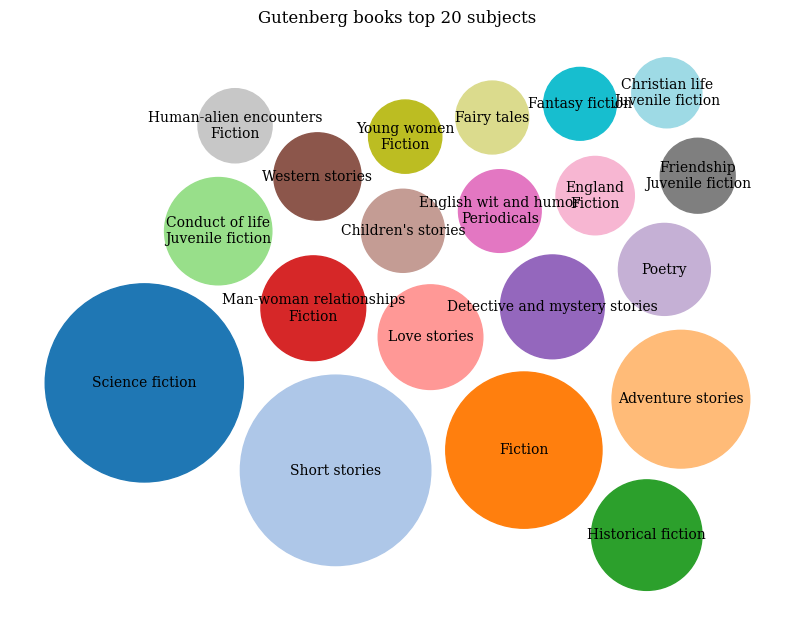

In [14]:
n = 20
gutenberg_books_subjects = {
    'subjects': gb.topn_subjects(n)['Subject'].replace({' -- ': '\n'}, regex=True).to_list(),
    'market_share': list(map(lambda x: x*n*3, gb.topn_subjects(n)['Count'].to_list())),
    'color': colors[:n]
}

bubble_chart = BubbleChart(area=gutenberg_books_subjects['market_share'],
                           bubble_spacing=2*n)

bubble_chart.collapse()

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"), figsize=(10, 10))
bubble_chart.plot(
    ax, gutenberg_books_subjects['subjects'], gutenberg_books_subjects['color'])
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title(f'Gutenberg books top {n} subjects')

plt.show()

## Authors

### Count distinct authors

There are currently $37392$ distinct authors.

In [15]:
len(gb.get_authors())

37494

### All authors
The `data_table` library can only deal with a maximum of $20000$ rows. If the number of rows exceeds this limit, the usual Pandas display is used (with no interactivity).


In [16]:
pd.DataFrame(gb.get_authors())

,0
0,"Jefferson, Thomas, 1743-1826"
1,United States
2,"Kennedy, John F. (John Fitzgerald), 1917-1963"
3,"Lincoln, Abraham, 1809-1865"
4,"Henry, Patrick, 1736-1799"
...,...
37489,"Betham-Edwards, Matilda, 1836-1919 [Editor]"
37490,"Johnston, Jas. F. W."
37491,"Suur-Juhola, Juhani"
37492,"Hart, Ellis"


### Top $n$ authors

In [17]:
n = 20000
gb.topn_authors(n)

Output hidden; open in https://colab.research.google.com to view.

### Ten random authors

In [18]:
gb.random_authors(10, 42).sort_values(by='Count', ascending=False)

,Author,Count
0,Various,3912
5,"Lytton, Edward Bulwer Lytton, Baron, 1803-1873",226
115,"Bennett, Arnold, 1867-1931",57
1077,"Spinoza, Benedictus de, 1632-1677",13
4851,"Wyatt, Edith, 1873-1958",3
4933,"Wilde, Percival, 1887-1953",3
10770,"Chrétien, de Troyes, active 12th century",2
9564,"McNair, John Frederick Adolphus, 1828-1910",2
32521,"Molin, Pelle, 1864-1896",1
23993,"Harned, Thomas Biggs, 1851-1921 [Editor]",1


### Visualize most frequent authors

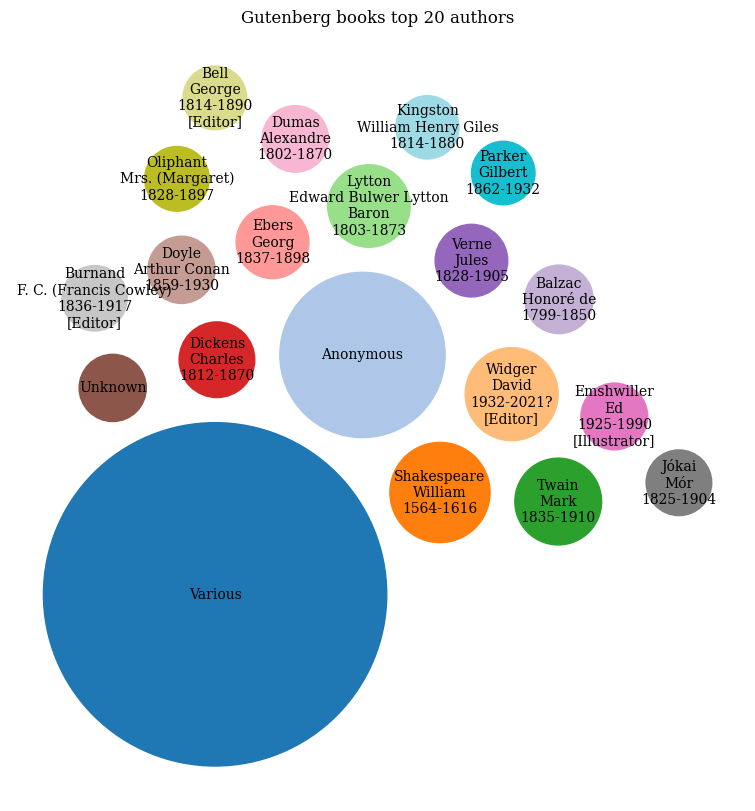

In [19]:
n = 20
gutenberg_books_authors = {
    'authors': gb.topn_authors(n)['Author'].replace({', ': '\n', ' \[': '\n['}, regex=True).to_list(),
    'market_share': list(map(lambda x: x*n*3, gb.topn_authors(n)['Count'].to_list())),
    'color': colors[:n]
}

bubble_chart = BubbleChart(area=gutenberg_books_authors['market_share'],
                           bubble_spacing=2*n)

bubble_chart.collapse()

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"),figsize=(10, 10))
bubble_chart.plot(
    ax, gutenberg_books_authors['authors'], gutenberg_books_authors['color'])
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title(f'Gutenberg books top {n} authors')

plt.show()

## Types

### All types

In [20]:
pd.DataFrame(gb.get_types(), columns=['Type'])

,Type
0,Text
1,Dataset
2,StillImage
3,MovingImage
4,Collection
5,Sound
6,Image


### Count books by types

In [21]:
grouped_counts = gb.catalog.groupby('Type').size().reset_index(name='Count')
grouped_counts

,Type,Count
0,Collection,4
1,Dataset,89
2,Image,33
3,MovingImage,8
4,Sound,1114
5,StillImage,3
6,Text,72109


### Visualize types

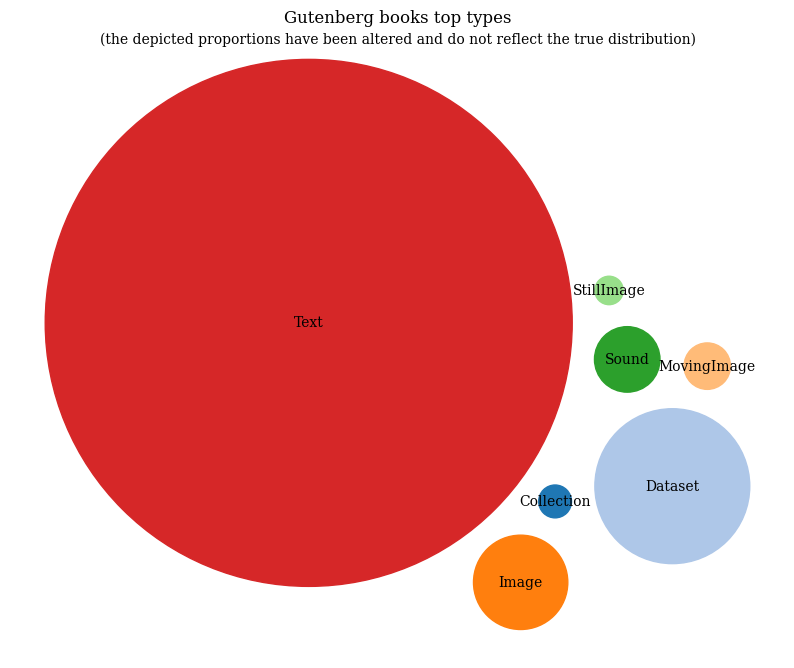

In [22]:
grouped_data = gb.catalog.groupby('Type').size().reset_index(name='Count')
n = len(grouped_data)
# Extracting values of 'Type' and 'Count' columns as lists
type_list = grouped_data['Type'].tolist()
count_list = grouped_data['Count'].tolist()
gutenberg_books_types = {
    'types': type_list,
    # adapt the size of smaller items
    'market_share': list(map(lambda x: x if x>1000 else x*n*10, count_list)),
    'color': colors[:-n]
}

bubble_chart = BubbleChart(area=gutenberg_books_types['market_share'],
                           bubble_spacing=2*n)

bubble_chart.collapse()

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"),figsize=(10, 10))
bubble_chart.plot(
    ax, gutenberg_books_types['types'], gutenberg_books_types['color'])
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title(f'Gutenberg books top types')
subtitle = "(the depicted proportions have been altered and do not reflect the true distribution)"
# Set the subtitle below the main title
plt.text(0.5, 0.98, subtitle, fontsize=10, ha='center', transform=plt.gca().transAxes)

plt.show()

I wasn't aware that the Gutenberg collection contained data other than text. I'll need to explore these additional data types at some point.

## Bookshelves

### Top $n$ bookshelves

In [23]:
n = 10
gb.topn_bookshelves(n)

,Bookshelf,Count
0,Science Fiction,1341
1,FR Littérature,1101
2,Children's Book Series,509
3,Punch,493
4,"Bestsellers, American, 1895-1923",426
5,Historical Fiction,384
6,DE Prosa,382
7,World War I,382
8,Children's Fiction,339
9,"FR Biographie, Mémoires, Journal intime, Corre...",324


### Visualize most frequent bookshelves

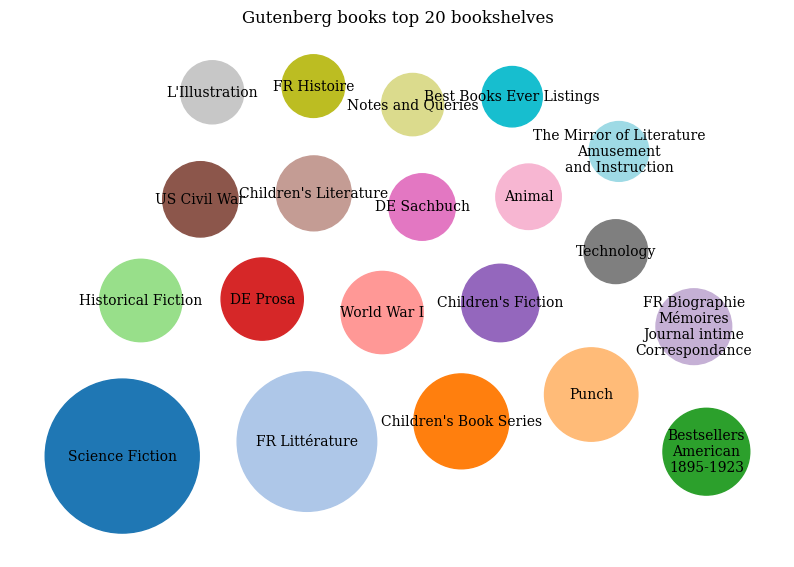

In [24]:
n = 20
gutenberg_books_bookshelves = {
    'bookshelves': gb.topn_bookshelves(n)['Bookshelf'].replace({', ': '\n'}, regex=True).to_list(),
    'market_share': list(map(lambda x: x*n*3, gb.topn_bookshelves(n)['Count'].to_list())),
    'color': colors[:n]
}

bubble_chart = BubbleChart(area=gutenberg_books_bookshelves['market_share'],
                           bubble_spacing=4*n)

bubble_chart.collapse()

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"), figsize=(10, 10))
bubble_chart.plot(
    ax, gutenberg_books_bookshelves['bookshelves'], gutenberg_books_bookshelves['color'])
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title(f'Gutenberg books top {n} bookshelves')

plt.show()

### Books without bookshelf

Many books do not belong to any bookshelf

In [25]:
gb.catalog.count()

Text#          73360
Type           73360
Issued         73360
Title          73360
Language       73360
Authors        73190
Subjects       73305
LoCC           73105
Bookshelves    17168
dtype: int64

### Number of books without bookshelf

In [26]:
print(f"Number of books with no bookshelf: {gb.catalog[gb.catalog['Bookshelves'].isna()].shape[0]}")

Number of books with no bookshelf: 56192


### Five random books without bookshelf

In [27]:
gb.catalog[gb.catalog['Bookshelves'].isna()].sample(n=5, replace=False, random_state=42)

,Text#,Type,Issued,Title,Language,Authors,Subjects,LoCC,Bookshelves
30799,30872,Text,2010-01-06,"A Collection of State-papers, Relative to the ...",en,"Adams, John, 1735-1826 [Compiler]",Law; United States -- Foreign relations -- Net...,E201,NaN
60395,60472,Text,2019-10-12,London Clubs: Their History & Treasures,en,"Nevill, Ralph, 1865-1930",London (England) -- Social life and customs; C...,DA; HS,NaN
31609,31682,Text,2010-03-18,Life of John Keats,en,"Rossetti, William Michael, 1829-1919","Poets, English -- 19th century -- Biography; K...",PR,NaN
42228,42302,Text,2013-03-10,Digters uit Suid-Afrika\r\nBloemlesing uit die...,af,"Celliers, Jan F. E. (Jan François Elias), 1865...",Afrikaans poetry,PT,NaN
7833,7876,Text,2005-04-01,"Passages from the English Notebooks, Volume 1.",en,"Hawthorne, Nathaniel, 1804-1864",England -- Description and travel; England -- ...,PS,NaN


## Languages

### Count distinct languages

The Gutenberg collection currently comprises 68 languages.

In [28]:
len(gb.get_languages())

68

### Top $n$ languages

In [29]:
gb.topn_languages(10)

,Language,Count
0,en,59077
1,fr,3769
2,fi,2894
3,de,2205
4,nl,1008
5,it,999
6,es,854
7,pt,640
8,hu,532
9,zh,444


### Visualize top $n$ languages

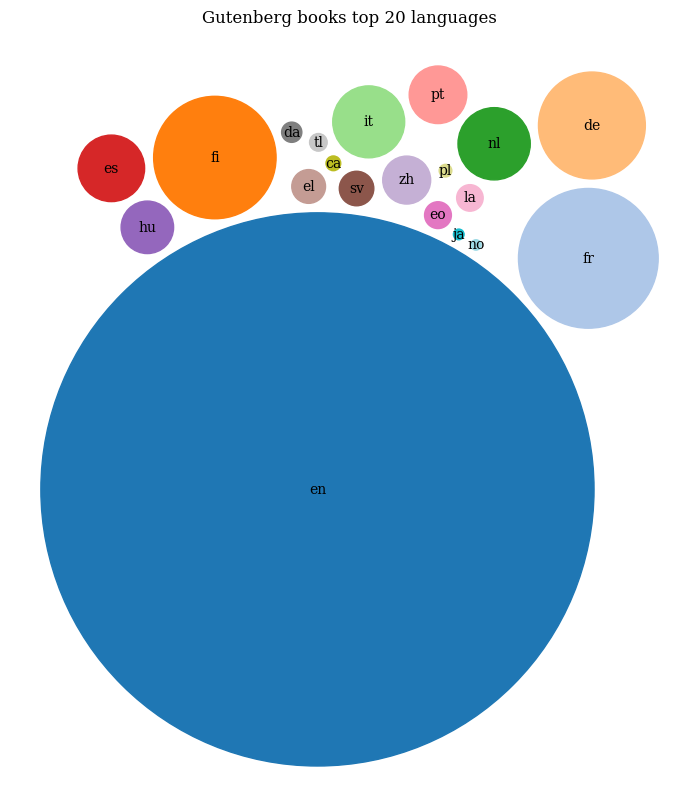

In [30]:
n = 20
gutenberg_books_languages = {
    'languages': gb.topn_languages(n)['Language'].to_list(),
    'market_share': list(map(lambda x: x*10, gb.topn_languages(n)['Count'].to_list())),
    'color': colors
}

bubble_chart = BubbleChart(area=gutenberg_books_languages['market_share'],
                           bubble_spacing=15)

bubble_chart.collapse()

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"), figsize=(10, 10))
bubble_chart.plot(
    ax, gutenberg_books_languages['languages'], gutenberg_books_languages['color'])
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title(f'Gutenberg books top {n} languages')

plt.show()

## Match books using various criteria

### Match books by subject

In [31]:
substr = "description and travel"
gb.books_matching_subject(substr)

,Text#,Type,Issued,Title,Language,Authors,Subjects,LoCC,Bookshelves
226,245,Text,2004-07-10,Life on the Mississippi,en,"Twain, Mark, 1835-1910",Mississippi River -- Description and travel; M...,PS,NaN
263,282,Text,1995-06-01,"Eothen; Or, Traces of Travel Brought Home from...",en,"Kinglake, Alexander William, 1809-1891",Middle East -- Description and travel; Kinglak...,DS,NaN
307,326,Text,1995-09-01,Steep Trails,en,"Muir, John, 1838-1914; Badè, William Frederic,...","West (U.S.) -- Description and travel; Shasta,...",F590.3,NaN
346,365,Text,2008-07-09,The Land of Little Rain,en,"Austin, Mary, 1868-1934",California -- Social life and customs; Natural...,F850.5,NaN
363,382,Text,1995-12-01,Edinburgh: Picturesque Notes,en,"Stevenson, Robert Louis, 1850-1894",Edinburgh (Scotland) -- Description and travel,DA,United Kingdom
...,...,...,...,...,...,...,...,...,...
73224,73305,Text,2024-03-31,Voyages of the Dutch brig of war Dourga,en,"Kolff, D. H. (Dirk Hendrik), 1800-1843; Earl, ...",New Guinea -- Description and travel; Maluku (...,DS,NaN
73247,73328,Text,2024-04-03,The outermost house,en,"Beston, Henry, 1888-1968",Naturalists -- United States -- Biography; Cap...,QH,NaN
73287,73368,Text,2024-04-10,Alpine notes and the climbing foot,en,"Wherry, George, 1852-1928",Mountaineering; Alps -- Description and travel,DQ,NaN
73317,73398,Text,2024-04-14,Travels in the East Indian archipelago,en,"Bickmore, Albert S. (Albert Smith), 1839-1914",Malay Archipelago -- Description and travel; I...,DS,NaN


### Match books by year

In [32]:
gb.books_matching_year(1984)

,Text#,Type,Issued,Title,Language,Authors,Subjects,LoCC,Bookshelves,match,Birth_Year,Death_Year
27,34,Text,1992-06-01,Zen and the Art of the Internet,en,"Kehoe, Brendan P., 1970-2011",Internet; Computer networks; Information netwo...,TK,NaN,0,1970,2011
66,88,Text,1993-11-01,Price/Cost Indexes from 1875 to 1989; Estimate...,en,"Hart, Michael, 1947-2011",Cost and standard of living,HG,NaN,0,1947,2011
187,250,Text,1995-04-01,A Brief History of the Internet\r\nThe Bright ...,en,"Fuller, Maxwell; Hart, Michael, 1947-2011",Internet -- History; Computer networks -- Unit...,TK,NaN,0,1947,2011
478,542,Text,1996-05-01,The Life of Me: An Autobiography,en,"Johnson, Clarence Edgar, 1906-1994","Johnson, Clarence Edgar, 1906-1994; Johnson fa...",CT; F350.5,Biographies,0,1906,1994
680,745,Dataset,1996-12-01,One Divided by Pi (To 1 Million Digits),en,"Kanada, Yasumasa, 1949-2020",Mathematics,QA,Mathematics,0,1949,2020
...,...,...,...,...,...,...,...,...,...,...,...,...
76236,73383,Text,2024-04-12,The great illusion,en,"Banister, Manly, 1914-1986; Freas, Kelly, 1922...",Science fiction; Short stories; Life on other ...,PS,NaN,0,1914,1986
76237,73383,Text,2024-04-12,The great illusion,en,"Banister, Manly, 1914-1986; Freas, Kelly, 1922...",Science fiction; Short stories; Life on other ...,PS,NaN,1,1922,2005
76239,73385,Text,2024-04-12,Woman's touch,en,"Smith, Evelyn E., 1922-2000; Emshwiller, Ed, 1...",Science fiction; Short stories; Human-alien en...,PS,NaN,0,1922,2000
76240,73385,Text,2024-04-12,Woman's touch,en,"Smith, Evelyn E., 1922-2000; Emshwiller, Ed, 1...",Science fiction; Short stories; Human-alien en...,PS,NaN,1,1925,1990


In [33]:
help(GutenbergBooks.books_matching_year)

Help on function books_matching_year in module __main__:

books_matching_year(self, given_year)
    Find books from the catalog that match a given year within the birth-death intervals of authors.
    
    Parameters:
    - given_year (int): The year to match within the birth-death intervals of authors.
    
    Returns:
    - DataFrame: A DataFrame containing books from the catalog where the given year falls within
                 the birth-death intervals of authors.
    
    This method extracts birth and death years from the 'Authors' column of the catalog and filters
    rows where the given year is within any birth-death interval. It returns a DataFrame of matching books.



# Downloading files from the Gutenberg collection

⚠️ Please read carefully this notice about the Gutenberg Project's policies on bulk downloading:



> “ _The Project Gutenberg website is intended for human users only. Any perceived use of automated tools to access the Project Gutenberg website will result in a temporary or permanent block of your IP address._ ”

See: https://www.gutenberg.org/policy/robot_access.html.


## The cache directory

By default, `GutenbergBooks` is the directory where all downloaded books are stored. If a book is alredy in the `GutenbergBooks` directory it won't be downloaded again.

⚠️ The cache directory is empty when you start your Google Colab session! ⚠️

## Download one book

In [34]:
gb.download_book(5687)

Retrieving pg5687.txt from https://www.gutenberg.org/cache/epub/5687/pg5687.txt.


'GutenbergBooks/pg5687.txt'

The same book won't be downloaded because it already exists in the cache directory `GutenbergBooks`.

In [35]:
gb.download_book(5687)

Book 5687 already exists in cache. Not downloading.


'GutenbergBooks/pg5687.txt'

In [36]:
help(GutenbergBooks.download_book)

Help on function download_book in module __main__:

download_book(self, nr)
    Download one book from the Gutenberg collection identified by its id.
    If the book already exists in the cache folder, it is not downloaded again.
    Parameters:
    - nr (int): id of the book in the Gutenberg books collection.
    Returns:
    - str: the path where the book was downloaded.



## Download multiple books

In [37]:
gb.download_books([5678, 5679, 5680])

Retrieving pg5678.txt from https://www.gutenberg.org/cache/epub/5678/pg5678.txt.
Retrieving pg5679.txt from https://www.gutenberg.org/cache/epub/5679/pg5679.txt.
Retrieving pg5680.txt from https://www.gutenberg.org/cache/epub/5680/pg5680.txt.


['GutenbergBooks/pg5678.txt',
 'GutenbergBooks/pg5679.txt',
 'GutenbergBooks/pg5680.txt']

In [38]:
help(GutenbergBooks.download_books)

Help on function download_books in module __main__:

download_books(self, books)
    Download a list of books from the Gutenberg collection.
    If a book already exists in the cache folder, it is not downloaded again.
    Parameters:
    - books (list): list of ids of books in the Gutenberg books collection.
    Returns:
    - str: the path where the book was downloaded.



## Download $n$ books by subject

In [39]:
gb.download_n_books(5, "\(South Africa\) -- Description and travel")

Retrieving pg886.txt from https://www.gutenberg.org/cache/epub/886/pg886.txt.
Retrieving pg21704.txt from https://www.gutenberg.org/cache/epub/21704/pg21704.txt.
Retrieving pg36951.txt from https://www.gutenberg.org/cache/epub/36951/pg36951.txt.
Retrieving pg40925.txt from https://www.gutenberg.org/cache/epub/40925/pg40925.txt.
Retrieving pg42737.txt from https://www.gutenberg.org/cache/epub/42737/pg42737.txt.


['GutenbergBooks/pg886.txt',
 'GutenbergBooks/pg21704.txt',
 'GutenbergBooks/pg36951.txt',
 'GutenbergBooks/pg40925.txt',
 'GutenbergBooks/pg42737.txt']

## Download a given amount of books by subject

DOwnload books matching a certain subject. Stop when the threshold given by the `size_mb` (size in Megabytes) parameter is reached.

If not specified, `size_mb` is $128$ (the default Hadoop block size).

In [40]:
gb.download_size_books(subject="\(South Africa\) -- Description and travel")

Book 886 already exists in cache. Not downloading.
Book 21704 already exists in cache. Not downloading.
Book 36951 already exists in cache. Not downloading.
Book 40925 already exists in cache. Not downloading.
Book 42737 already exists in cache. Not downloading.
Retrieving pg42767.txt from https://www.gutenberg.org/cache/epub/42767/pg42767.txt.
Retrieving pg53574.txt from https://www.gutenberg.org/cache/epub/53574/pg53574.txt.
Retrieving pg63906.txt from https://www.gutenberg.org/cache/epub/63906/pg63906.txt.
Retrieving pg63920.txt from https://www.gutenberg.org/cache/epub/63920/pg63920.txt.
Retrieving pg66742.txt from https://www.gutenberg.org/cache/epub/66742/pg66742.txt.
Book 886 already exists in cache. Not downloading.
Book 21704 already exists in cache. Not downloading.
Book 36951 already exists in cache. Not downloading.
Book 40925 already exists in cache. Not downloading.
Book 42737 already exists in cache. Not downloading.
Book 42767 already exists in cache. Not downloading.
B

['GutenbergBooks/pg886.txt',
 'GutenbergBooks/pg21704.txt',
 'GutenbergBooks/pg36951.txt',
 'GutenbergBooks/pg40925.txt',
 'GutenbergBooks/pg42737.txt',
 'GutenbergBooks/pg42767.txt',
 'GutenbergBooks/pg53574.txt',
 'GutenbergBooks/pg63906.txt',
 'GutenbergBooks/pg63920.txt',
 'GutenbergBooks/pg66742.txt']

In [41]:
!du -sh GutenbergBooks

5.0M	GutenbergBooks


In [42]:
subject = "United States -- Description and travel"
gb.download_size_books(size_mb=90, subject=subject)

Retrieving pg675.txt from https://www.gutenberg.org/cache/epub/675/pg675.txt.
Retrieving pg968.txt from https://www.gutenberg.org/cache/epub/968/pg968.txt.
Retrieving pg977.txt from https://www.gutenberg.org/cache/epub/977/pg977.txt.
Retrieving pg1082.txt from https://www.gutenberg.org/cache/epub/1082/pg1082.txt.
Retrieving pg1865.txt from https://www.gutenberg.org/cache/epub/1865/pg1865.txt.
Retrieving pg1866.txt from https://www.gutenberg.org/cache/epub/1866/pg1866.txt.
Retrieving pg2869.txt from https://www.gutenberg.org/cache/epub/2869/pg2869.txt.
Retrieving pg3547.txt from https://www.gutenberg.org/cache/epub/3547/pg3547.txt.
Retrieving pg4666.txt from https://www.gutenberg.org/cache/epub/4666/pg4666.txt.
Retrieving pg6445.txt from https://www.gutenberg.org/cache/epub/6445/pg6445.txt.
Retrieving pg6874.txt from https://www.gutenberg.org/cache/epub/6874/pg6874.txt.
Retrieving pg6876.txt from https://www.gutenberg.org/cache/epub/6876/pg6876.txt.
Retrieving pg7237.txt from https://ww

['GutenbergBooks/pg675.txt',
 'GutenbergBooks/pg968.txt',
 'GutenbergBooks/pg977.txt',
 'GutenbergBooks/pg1082.txt',
 'GutenbergBooks/pg1865.txt',
 'GutenbergBooks/pg1866.txt',
 'GutenbergBooks/pg2869.txt',
 'GutenbergBooks/pg3547.txt',
 'GutenbergBooks/pg4666.txt',
 'GutenbergBooks/pg6445.txt',
 'GutenbergBooks/pg6874.txt',
 'GutenbergBooks/pg6876.txt',
 'GutenbergBooks/pg7237.txt',
 'GutenbergBooks/pg7526.txt',
 'GutenbergBooks/pg7997.txt',
 'GutenbergBooks/pg9693.txt',
 'GutenbergBooks/pg9699.txt',
 'GutenbergBooks/pg10345.txt',
 'GutenbergBooks/pg10619.txt',
 'GutenbergBooks/pg10637.txt',
 'GutenbergBooks/pg10857.txt',
 'GutenbergBooks/pg10898.txt',
 'GutenbergBooks/pg11013.txt',
 'GutenbergBooks/pg11329.txt',
 'GutenbergBooks/pg11454.txt',
 'GutenbergBooks/pg11545.txt',
 'GutenbergBooks/pg11725.txt',
 'GutenbergBooks/pg12022.txt',
 'GutenbergBooks/pg12266.txt',
 'GutenbergBooks/pg12380.txt',
 'GutenbergBooks/pg13095.txt',
 'GutenbergBooks/pg14191.txt',
 'GutenbergBooks/pg15463.txt

In [43]:
!du -sh GutenbergBooks

83M	GutenbergBooks


It's not easy to get enough data!

In [44]:
subject = "California -- Description and travel"
gb.download_size_books(size_mb=50, subject=subject)

Retrieving pg365.txt from https://www.gutenberg.org/cache/epub/365/pg365.txt.
Retrieving pg465.txt from https://www.gutenberg.org/cache/epub/465/pg465.txt.
Retrieving pg516.txt from https://www.gutenberg.org/cache/epub/516/pg516.txt.
Retrieving pg3126.txt from https://www.gutenberg.org/cache/epub/3126/pg3126.txt.
Retrieving pg3311.txt from https://www.gutenberg.org/cache/epub/3311/pg3311.txt.
Retrieving pg4636.txt from https://www.gutenberg.org/cache/epub/4636/pg4636.txt.
Retrieving pg4755.txt from https://www.gutenberg.org/cache/epub/4755/pg4755.txt.
Retrieving pg10012.txt from https://www.gutenberg.org/cache/epub/10012/pg10012.txt.
Retrieving pg10217.txt from https://www.gutenberg.org/cache/epub/10217/pg10217.txt.
Book 12022 already exists in cache. Not downloading.
Retrieving pg12518.txt from https://www.gutenberg.org/cache/epub/12518/pg12518.txt.
Retrieving pg12564.txt from https://www.gutenberg.org/cache/epub/12564/pg12564.txt.
Retrieving pg13002.txt from https://www.gutenberg.org

['GutenbergBooks/pg365.txt',
 'GutenbergBooks/pg465.txt',
 'GutenbergBooks/pg516.txt',
 'GutenbergBooks/pg3126.txt',
 'GutenbergBooks/pg3311.txt',
 'GutenbergBooks/pg4636.txt',
 'GutenbergBooks/pg4755.txt',
 'GutenbergBooks/pg10012.txt',
 'GutenbergBooks/pg10217.txt',
 'GutenbergBooks/pg12022.txt',
 'GutenbergBooks/pg12518.txt',
 'GutenbergBooks/pg12564.txt',
 'GutenbergBooks/pg13002.txt',
 'GutenbergBooks/pg13222.txt',
 'GutenbergBooks/pg13298.txt',
 'GutenbergBooks/pg13321.txt',
 'GutenbergBooks/pg19479.txt',
 'GutenbergBooks/pg23280.txt',
 'GutenbergBooks/pg24816.txt',
 'GutenbergBooks/pg28034.txt',
 'GutenbergBooks/pg32178.txt',
 'GutenbergBooks/pg36680.txt',
 'GutenbergBooks/pg39497.txt',
 'GutenbergBooks/pg42579.txt',
 'GutenbergBooks/pg44764.txt',
 'GutenbergBooks/pg46110.txt',
 'GutenbergBooks/pg48142.txt',
 'GutenbergBooks/pg48156.txt',
 'GutenbergBooks/pg48407.txt',
 'GutenbergBooks/pg51893.txt',
 'GutenbergBooks/pg54422.txt',
 'GutenbergBooks/pg57580.txt',
 'GutenbergBooks/p

In [45]:
!du -sh GutenbergBooks

96M	GutenbergBooks


# Acknowledgements and some thoughts on Artificial Intelligence

For this tutorial I've made extensive use of the ChatGPT (version $3.5$) AI to:
- improve my English
- define code structure
- write Python code snippets
- document code

I ideated, organized, adapted, double-checked all content (both text and code) with the aim of creating a useful tool for exploring the Gutenberg books collection and providing a pleasant user experience.

I can imagine that in the future AI will be able to write such tutorials on their own and then the role of a tutorial author will be limited to defining requirements. Maybe there are going to be self-adapting tutorials that create themselves on the spot according to the needs of the readers, thus bypassing the need for tutorial authors. What are tutorial authors going to do then? Something else 😀!


In this spirit, I'd like to thank everyone who contributed to the common sense language collection (both natural and programming languages) used to train ChatGPT, the creators of ChatGPT, and the companies making it available as a comfortable Web application.

In [46]:
print("Nguyen Kim Hoang Anh 22022566")

Nguyen Kim Hoang Anh 22022566
